TEST TEST.

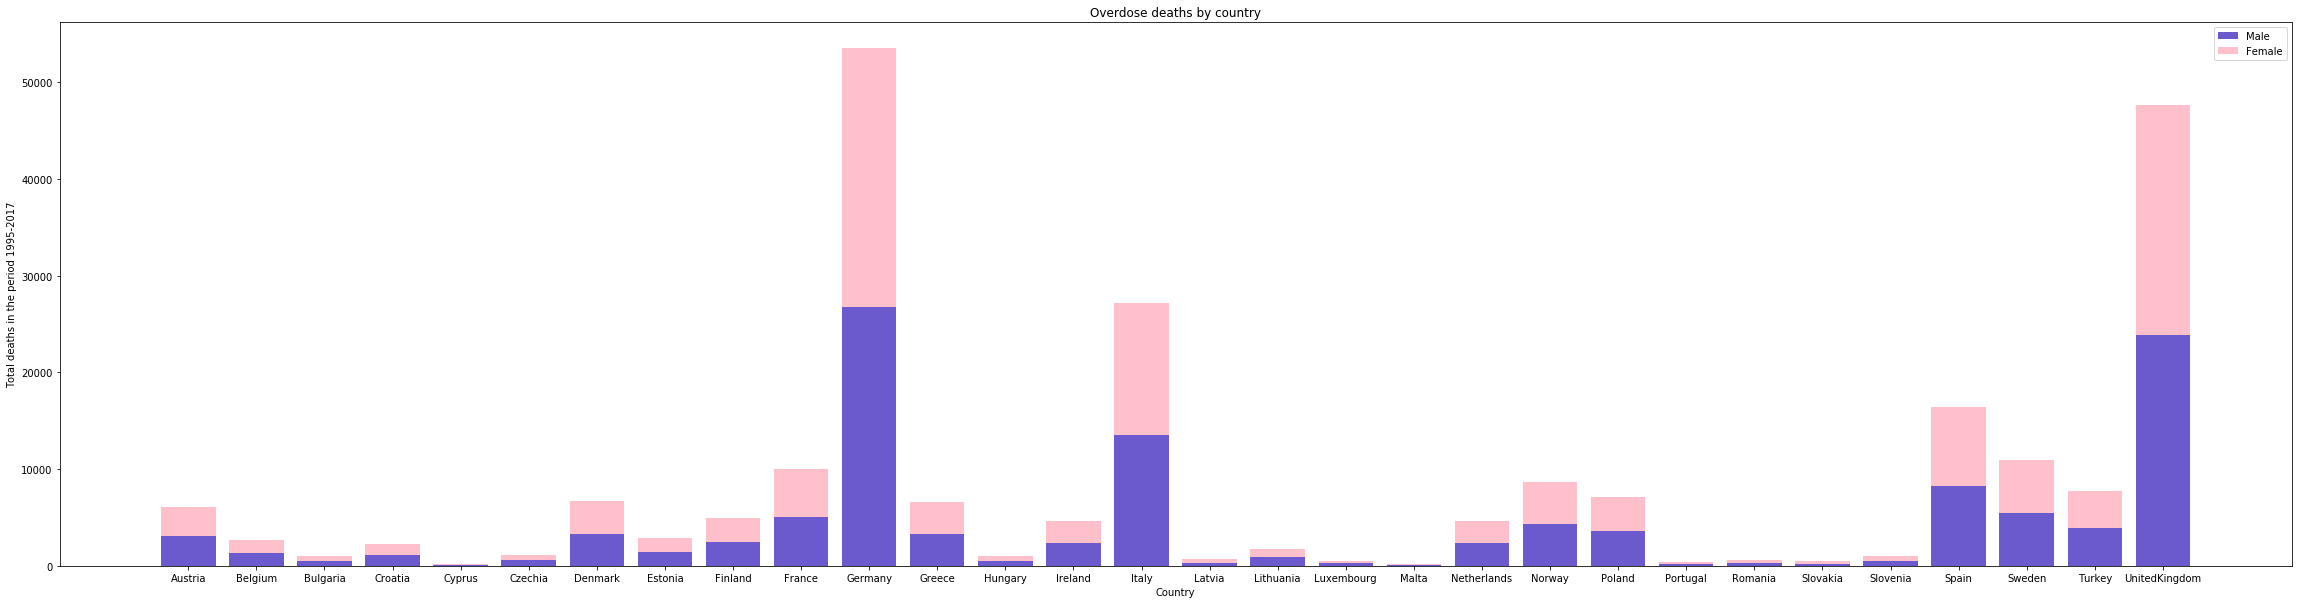

In [87]:
import pandas
import matplotlib.pyplot as plt
import numpy as np



m = pandas.read_excel("./tables/drugDeaths/maleDeaths.xlsx")
m.fillna(0)
f = pandas.read_excel("./tables/drugDeaths/maleDeaths.xlsx") 
f.fillna(0)
plt.figure(figsize=(40,10))

dataM = {}
dataF = {}
def replaceNan(data, indxs, val):
    for (i,v) in enumerate(indxs):
        if v == True:
            data[i] = val
for i,row in m.iterrows():
    if type(row["Country"]) is str:
        country = row["Country"].replace(" ", "").replace("*", "")
        dataM[country] = [row[col] for col in m.columns[:-1][1:]]
        nan_indx = np.isnan(dataM[country])
        replaceNan(dataM[country], nan_indx,0)
    
for i,row in f.iterrows():
    if type(row["Country"]) is str:
        country = row["Country"].replace("*", "").replace(" ", "")
        dataF[country] = [row[col] for col in f.columns[:-1][1:]]
        nan_indx = np.isnan(dataF[country])
        replaceNan(dataF[country], nan_indx,0)

    
X = dataM.keys()
maleY=[sum(dataM[k])  for k in dataM.keys()]
femaleY=[sum(dataF[k])  for k in dataM.keys()]

plt.bar(X, maleY, color="slateblue", label="Male")
plt.bar(X, femaleY, bottom = maleY ,color="pink", label="Female")

plt.title("Overdose deaths by country")
plt.xlabel("Country")
plt.ylabel("Total deaths in the period 1995-2017")


plt.legend()


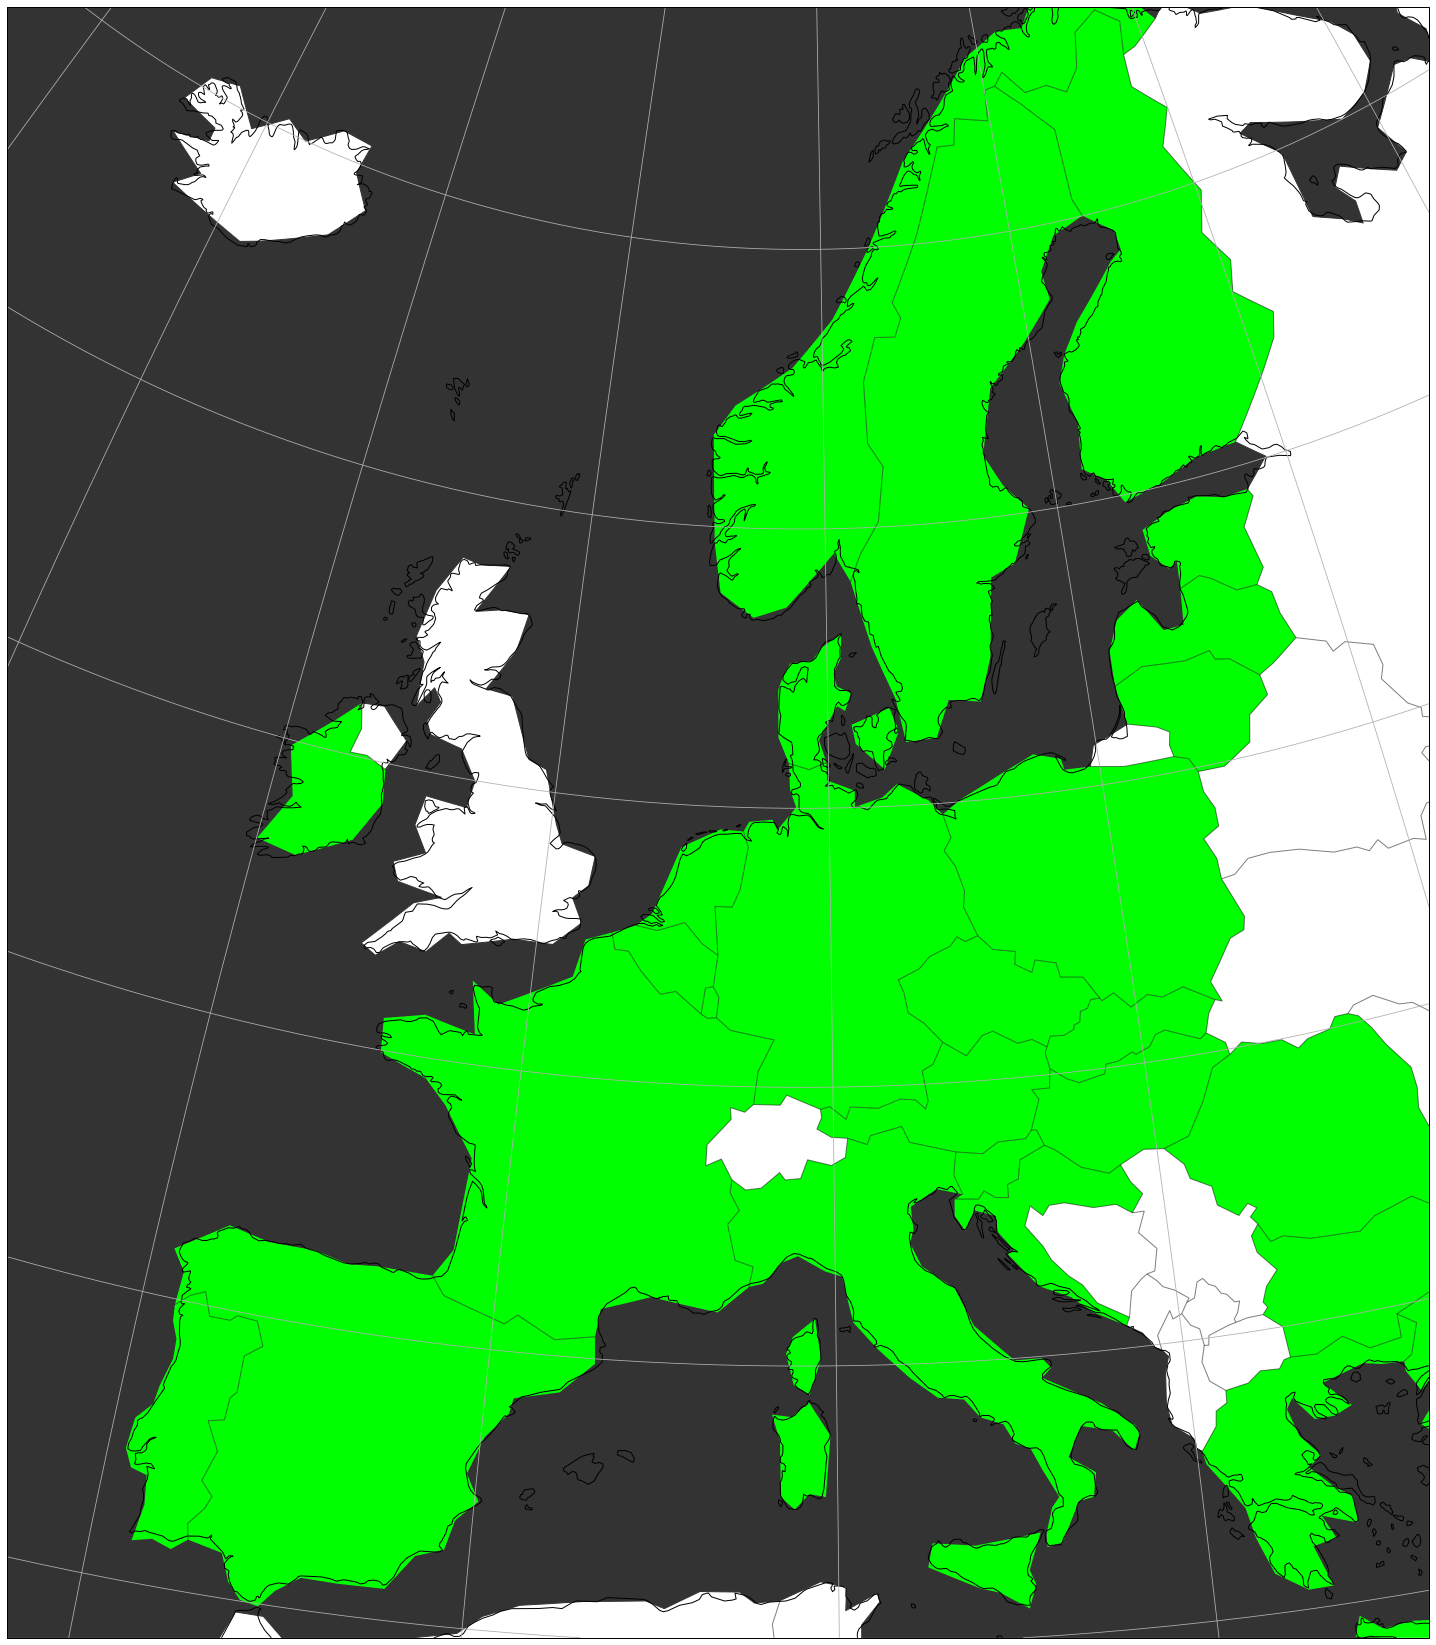

In [89]:
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs

plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.EuroPP())

shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
for country in countries:
    if country.attributes["NAME"] in data:
        
        ax.add_geometries([country.geometry], crs=ccrs.PlateCarree(), facecolor=(0, 1, 0))
plt.rcParams["figure.figsize"] = (50,50)

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.OCEAN,facecolor=(0.2,0.2,0.2))
ax.gridlines()